In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# reading the file
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

In [3]:
# displaying the top 5 rows of the dataset.
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [4]:
TARGET_CATEGORIES = ["POLITICS", "BUSINESS", "SPORTS"]
RECORDS_PER_CATEGORY = 5000
RANDOM_SEED = 42

# Converting the category names to all caps for filtering
df['category'] = df['category'].str.upper()

# Filter and sample 5,000 records for each of the three categories
sampled_dfs = []
for category in TARGET_CATEGORIES:
    df_category = df[df['category'] == category]
    
    # Sample the required number of records
    df_sampled = df_category.sample(n=RECORDS_PER_CATEGORY, random_state=RANDOM_SEED)
    sampled_dfs.append(df_sampled)

# Concatenating the sampled DataFrames and select only the required columns
df_final = pd.concat(sampled_dfs, ignore_index=True)
df_final = df_final[['headline', 'category']]

# Shuffling the final DataFrame
df_final = df_final.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# The resulting balanced DataFrame with 15,000 records is stored in df_final
print(f"Final DataFrame shape: {df_final.shape}")
print(df_final.head())

Final DataFrame shape: (15000, 2)
                                            headline  category
0  Houston Astros On The Brink Of World Series Cr...    SPORTS
1  Why My Toaster Loves My Car: Are You Ready for...  BUSINESS
2                                      Et Tu, Media?    SPORTS
3            Sarah Palin's Excuse For Speeding Is...  POLITICS
4               Yogi Berra and the Greek Debt Crisis  BUSINESS


#### The final balanced dataset of 15,000 records by filtering and sampling 5,000 headlines from each of the three target categories before shuffling the final DataFrame.

In [6]:
# Checking for any missing values
df_final.isnull().sum()

headline    0
category    0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

# Separate features (X) and labels (y)
X = df_final['headline']
y = df_final['category']

# X_train is 70% (10,500 records)
# X_test is 20% (3,000 records)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, 
    test_size=0.20,      # 20% for testing (3,000 records)
    stratify=y,          # To Maintain class balance
    random_state=42)

# The test_size is set to be 0.125 (10% / 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.125,     # 10% of total (1,500 records)
    stratify=y_train_val, # Maintain class balance
    random_state=42)

# Final check of sizes
print(f"Training Set (70%): {len(X_train)} records")
print(f"Validation Set (10%): {len(X_val)} records")
print(f"Testing Set (20%): {len(X_test)} records")

Training Set (70%): 10500 records
Validation Set (10%): 1500 records
Testing Set (20%): 3000 records


#### Spliting the 15,000-record final dataset into a 20% testing set (3,000 records), 70% training set (10,500 records) and 10% validation set (1500 records) while ensuring the class balance is maintained using stratification.

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [10]:
# Installing gensim
!pip install gensim

In [11]:
import gensim.downloader as api

# Downloading pre-trained Word2Vec Google News embeddings (300 dimensions)
model = api.load("word2vec-google-news-300")

In [12]:
def remove_missing(data_input, w2v):
    # To Ensure the input is a string
    if not isinstance(data_input, str):
        return ""
    # Keeping only the words present in the word2vec vocabulary
    return ' '.join(word for word in data_input.split() if word in w2v)


import pandas as pd

# Applying the function safely to each text entry
X_train_processed = X_train.apply(lambda text: remove_missing(text, model))
X_val_processed = X_val.apply(lambda text: remove_missing(text, model))
X_test_processed = X_test.apply(lambda text: remove_missing(text, model))

In [13]:
# Checking the shape of each set
print(X_train_processed.shape)
print(X_val_processed.shape)
print(X_test_processed.shape)

(10500,)
(1500,)
(3000,)


In [14]:
# Tokenization (Creating Vocabulary)

# Using the Tokenizer to create a vocabulary based on the training/validation data
# set the num_words to None to keep all words initially.
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_processed)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # +1 for the 0-index reserved for padding

In [15]:
import pandas as pd

# Combining train and validation text
all_texts = pd.concat([X_train_processed, X_val_processed], ignore_index=True)

# Computing maximum length safely
MAX_CONTEXT_LENGTH = max(
    len(str(s).split()) 
    for s in all_texts 
    if isinstance(s, str) and s.strip()
)

MAX_CONTEXT_LENGTH

24

In [16]:
# Converting processed text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(X_train_processed)
val_sequences = tokenizer.texts_to_sequences(X_val_processed)
test_sequences = tokenizer.texts_to_sequences(X_test_processed)

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding train, validation, and test sequences
X_train = pad_sequences(train_sequences, maxlen=MAX_CONTEXT_LENGTH, padding='post', truncating='post')
X_val = pad_sequences(val_sequences, maxlen=MAX_CONTEXT_LENGTH, padding='post', truncating='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_CONTEXT_LENGTH, padding='post', truncating='post')

# Check shapes
X_train.shape, X_val.shape, X_test.shape

((10500, 24), (1500, 24), (3000, 24))

In [18]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Fit the label encoder only on the training + validation labels (not on test)
le = LabelEncoder()
le.fit(pd.concat([y_train, y_val], ignore_index=True))

# Transform each set separately
y_train_encoded = le.transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)


from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train_encoded)
y_val_oh = to_categorical(y_val_encoded)
y_test_oh = to_categorical(y_test_encoded)

In [19]:
print(f"Vocabulary Size: {vocab_size}")
print(f"Max Headline Length (Context Size): {MAX_CONTEXT_LENGTH}")
print(f"Training data shape: {X_train.shape}, Labels shape: {y_train_oh.shape}")

Vocabulary Size: 11951
Max Headline Length (Context Size): 24
Training data shape: (10500, 24), Labels shape: (10500, 3)


In [20]:
# Creating the Embedding Matrix
if model:
    # Initializing matrix with zeros. The first row (index 0) will remain zero for padding.
    embedding_matrix = np.zeros((vocab_size, 300))
    
    missing_words_count = 0
    missing_words = []
    
    # Iterating through your vocabulary (word_index)
    for word, i in word_index.items():
        if word in model:
            # If word is found, copy the pre-trained vector
            embedding_matrix[i] = model[word]
        else:
            # Word not found in the Word2Vec vocabulary
            missing_words_count += 1
            missing_words.append(word)
            # The row remains zero

    print(f"\nTotal words in vocabulary: {vocab_size - 1}")
    print(f"Words missing from Word2Vec vocabulary: {missing_words_count} ({missing_words_count / (vocab_size - 1) * 100:.2f}%)")


Total words in vocabulary: 11950
Words missing from Word2Vec vocabulary: 1159 (9.70%)


#### Downloading the pre-trained Word2Vec embeddings and creates the non-trainable embedding matrix for the model, assigning zero vectors to words not found in the Google News vocabulary.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model 1: FFN Classifier

In [24]:
# Defining the FFN Model Architecture
num_classes = 3
def create_ffn_model(embedding_matrix, max_len, num_classes):
    model = Sequential([
        # Layer 1: Embedding layer
        Embedding(
            input_dim=embedding_matrix.shape[0],      # Vocab size
            output_dim=embedding_matrix.shape[1],     # Embedding dim (300)
            weights=[embedding_matrix],               # **Pre-trained Word2Vec weights**
            input_length=max_len,                     # Max context length
            trainable=False                           # **CRUCIAL: Embeddings are NOT trainable**
        ),
        
        # Layer 2: Flatten - Converts the sequence (Max_Len x 300) to a single vector (Max_Len * 300)
        Flatten(),
        
        # Layer 3: Hidden Layer (Trial-and-Error Architecture)
        Dense(512, activation='relu'),
        
        # Layer 4: Hidden Layer (Trial-and-Error Architecture)
        Dense(128, activation='relu'),
        
        # Layer 5: Output Layer 
        Dense(num_classes, activation='softmax') # **Categorical Cross Entropy Loss requires softmax**
    ])
    
    # Compiling the model
    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', # **Required loss function**
        metrics=['accuracy']
    )
    return model

ffn_model = create_ffn_model(embedding_matrix, MAX_CONTEXT_LENGTH, num_classes)

# model summary 
ffn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,585,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585,300 (13.68 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,585,300 (13.68 MB)

In [25]:
# Training the FFN Model
BATCH_SIZE = 128 # Trial-and-error batch size
EPOCHS = 30     # Setting a reasonable max, EarlyStopping will prevent overfitting

# Callbacks for using the validation set to stop training when performance plateaus
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_ffn_model.keras', monitor='val_loss', save_best_only=True, verbose=0)
]

print("\nStarting FFN Model Training...")
ffn_history = ffn_model.fit(
    X_train, 
    y_train_oh, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_val, y_val_oh), 
    callbacks=callbacks,
    verbose=1
)

print("\nFFN Model Training Complete.")


Starting FFN Model Training...
Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6927 - loss: 0.6839 - val_accuracy: 0.8267 - val_loss: 0.4597
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9077 - loss: 0.2635 - val_accuracy: 0.8133 - val_loss: 0.4784
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9624 - loss: 0.1247 - val_accuracy: 0.8080 - val_loss: 0.6023
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9793 - loss: 0.0724 - val_accuracy: 0.7853 - val_loss: 0.7630
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9969 - loss: 0.0144 - val_accuracy: 0.7973 - val_loss: 0.8901
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.

FFN Model Training Complete.


In [26]:
from sklearn.metrics import classification_report

In [27]:
# Using the trained model (ffn_model) to predict probabilities on the test set
y_pred_probs = ffn_model.predict(X_test, verbose=0)

# Converting probabilities to class labels (index of the max probability)
y_pred_indices = np.argmax(y_pred_probs, axis=1)

# Converting true one-hot labels back to class indices
y_true_indices = np.argmax(y_test_oh, axis=1)

In [28]:
# Decoding the indices back to original class names (POLITICS, BUSINESS, SPORTS)
target_names = le.inverse_transform(np.unique(y_true_indices))
y_true_labels = le.inverse_transform(y_true_indices)
y_pred_labels = le.inverse_transform(y_pred_indices)

In [29]:
# Classification Report
# 1. Per-class Precision, Recall, F1-score
# 2. Micro and Macro Averages of Precision, Recall, and F1-score (Micro average is the same as accuracy for balanced data)

# Generating the report.
ffn_report = classification_report(
    y_true_labels, 
    y_pred_labels, 
    target_names=target_names,
    output_dict=True,
    zero_division=0 # Prevents warnings if a class has zero predicted samples
)

# Converting the report dictionary to a DataFrame for clean formatting
df_report_ffn = pd.DataFrame(ffn_report).transpose()

#### The FFN model's performance on the test set is calculated by generating class predictions and creating the comprehensive classification report.

In [31]:
# per-class Precision, per-class Recall, per-class F1 score
print("\nPer-Class Metrics:")
print(df_report_ffn.loc[target_names, ['precision', 'recall', 'f1-score']])


Per-Class Metrics:
          precision  recall  f1-score
BUSINESS   0.773206   0.808  0.790220
POLITICS   0.796842   0.757  0.776410
SPORTS     0.835821   0.840  0.837905


In [32]:
# micro averages of precision, recall, and F1 score.
micro_avg_value = ffn_report['accuracy']

print("\nMicro Averages (Overall Performance):")
print(f"  Micro Average Precision: {micro_avg_value:.4f}")
print(f"  Micro Average Recall: {micro_avg_value:.4f}")
print(f"  Micro Average F1-score: {micro_avg_value:.4f}")


Micro Averages (Overall Performance):
  Micro Average Precision: 0.8017
  Micro Average Recall: 0.8017
  Micro Average F1-score: 0.8017


In [33]:
# Macro average values
print("\nMacro Averages:")
print(f"  Macro Average Precision: {ffn_report['macro avg']['precision']:.4f}")
print(f"  Macro Average Recall: {ffn_report['macro avg']['recall']:.4f}")
print(f"  Macro Average F1-score: {ffn_report['macro avg']['f1-score']:.4f}")


Macro Averages:
  Macro Average Precision: 0.8020
  Macro Average Recall: 0.8017
  Macro Average F1-score: 0.8015


In [34]:
metrics_df_ffn = df_report_ffn.loc[target_names, ['precision', 'recall', 'f1-score']]

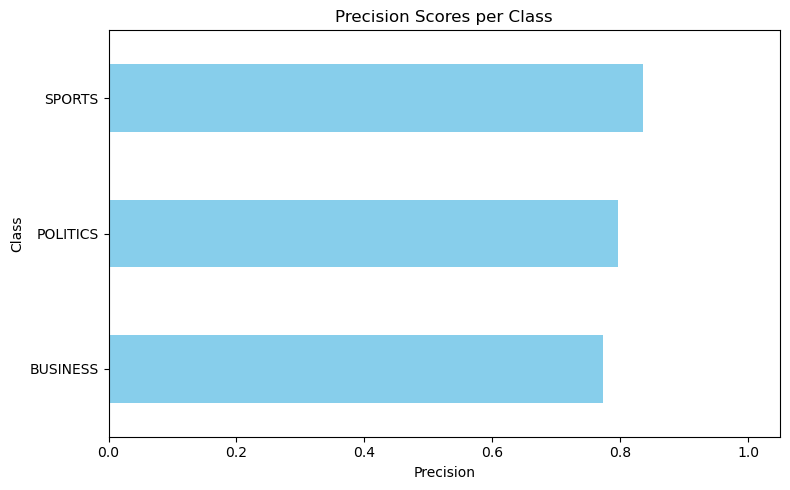

In [35]:
# Plot 1: Precision Scores
plt.figure(figsize=(8, 5))
metrics_df_ffn['precision'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Precision Scores per Class')
plt.xlabel('Precision')
plt.ylabel('Class')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

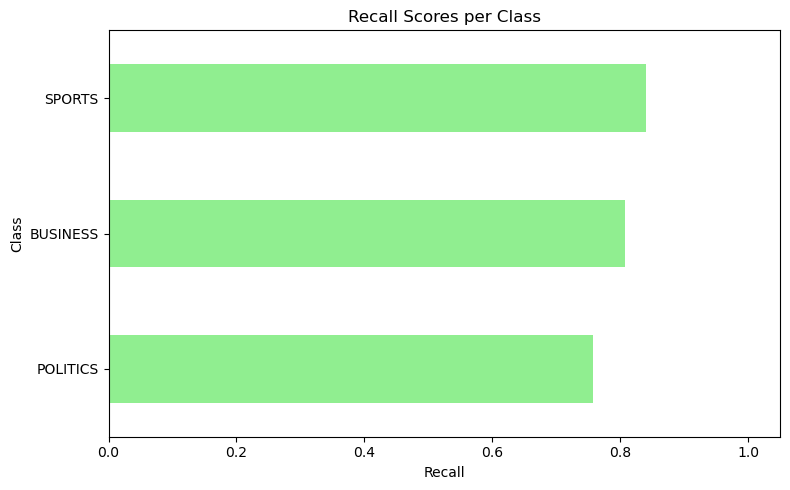

In [36]:
# Plot 2: Recall Scores
plt.figure(figsize=(8, 5))
metrics_df_ffn['recall'].sort_values().plot(kind='barh', color='lightgreen')
plt.title('Recall Scores per Class')
plt.xlabel('Recall')
plt.ylabel('Class')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

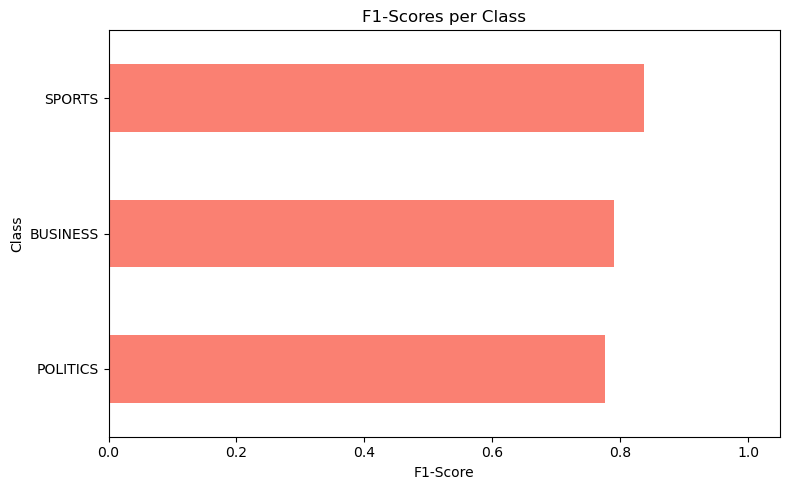

In [37]:
# Plot 3: F1-Scores
plt.figure(figsize=(8, 5))
metrics_df_ffn['f1-score'].sort_values().plot(kind='barh', color='salmon')
plt.title('F1-Scores per Class')
plt.xlabel('F1-Score')
plt.ylabel('Class')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

#### Separate bar charts are generated to visualize the FFN model's per-class Precision, Recall, and F1-score metrics.

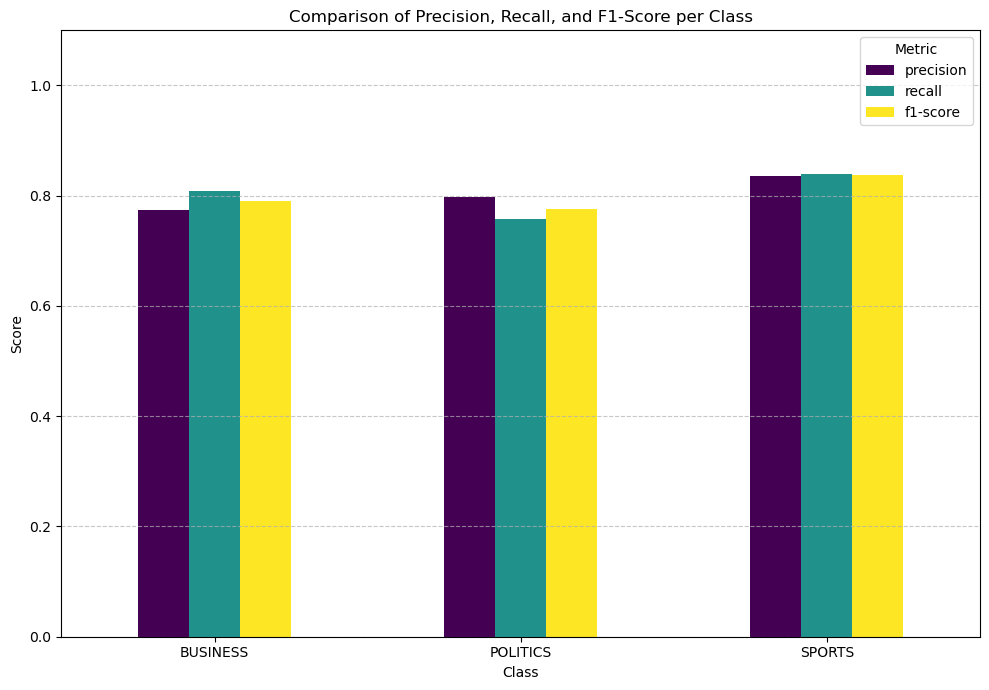

In [39]:
# Plot 4: Comparison of All Metrics
metrics_df_ffn.plot(kind='bar', figsize=(10, 7), colormap='viridis')
plt.title('Comparison of Precision, Recall, and F1-Score per Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### A grouped bar chart is created to compare all FFN evaluation metrics (Precision, Recall, and F1-score) across the three categories.

# Model 2: RNN - GRU model

In [42]:
# Model Definition
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

NUM_CLASSES = 3 
GRU_NODES = 128  # Trial-and-error
BATCH_SIZE = 64  # Trial-and-error 
EPOCHS = 30 

def create_rnn_model(embedding_matrix, max_len, num_classes):
    model = Sequential([
        # 1. Embedding Layer: Non-trainable Word2Vec weights
        Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False
        ),
        
        # 2. RNN Layer: GRU to process sequential data
        GRU(GRU_NODES, return_sequences=False),
        
        # 3. Optional Dropout for regularization
        Dropout(0.3),
        
        # 4. FFN Classification Head
        Dense(num_classes, activation='softmax')
    ])

    # Compiling the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

rnn_model = create_rnn_model(embedding_matrix, MAX_CONTEXT_LENGTH, NUM_CLASSES)

In [43]:
# Model summary
rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     3,585,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585,300 (13.68 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,585,300 (13.68 MB)

In [44]:
# Model Training
# Callbacks for better training control
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_gru_model.keras', monitor='val_loss', save_best_only=True, verbose=0)
]

print("\nStarting GRU-based RNN Model Training...")
rnn_history = rnn_model.fit(
    X_train,
    y_train_oh,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_oh),
    callbacks=callbacks,
    verbose=1
)

print("\nGRU-based RNN Model Training Complete.")


Starting GRU-based RNN Model Training...
Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5017 - loss: 0.9089 - val_accuracy: 0.8080 - val_loss: 0.4964
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8211 - loss: 0.4641 - val_accuracy: 0.8367 - val_loss: 0.4566
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8406 - loss: 0.4212 - val_accuracy: 0.8267 - val_loss: 0.4326
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8605 - loss: 0.3782 - val_accuracy: 0.8393 - val_loss: 0.4238
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8688 - loss: 0.3605 - val_accuracy: 0.8447 - val_loss: 0.4120
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8807 - loss: 0.3257 - val_accuracy: 0.8400 - val_loss: 0.4084
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8817 - loss: 0.3194 - val_accuracy: 0.8513 - val_loss: 0.4191
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - 

In [45]:
# Generating Predictions
y_pred_probs = rnn_model.predict(X_test, verbose=0)
y_pred_indices = np.argmax(y_pred_probs, axis=1)

In [46]:
# retriving true indices from one-hot encoding
y_true_indices = np.argmax(y_test_oh, axis=1)

In [47]:
# Decoding Labels
target_names = le.inverse_transform(np.unique(y_true_indices))
y_true_labels = le.inverse_transform(y_true_indices)
y_pred_labels = le.inverse_transform(y_pred_indices)

In [48]:
# Computing Classification Report
rnn_report = classification_report(
    y_true_labels, 
    y_pred_labels, 
    target_names=target_names,
    output_dict=True,
    zero_division=0 
)

#### The RNN model's performance on the test set is calculated by generating class predictions and creating the comprehensive classification report.

In [50]:
# computing per-class Precision, per-class Recall, per-class F1 score
df_report_rnn = pd.DataFrame(rnn_report).transpose()
df_per_class = df_report_rnn.loc[target_names, ['precision', 'recall', 'f1-score']]

print("RNN Classifier: Per-Class Performance on Test Data")
print(df_report_rnn.loc[target_names, ['precision', 'recall', 'f1-score']])

RNN Classifier: Per-Class Performance on Test Data
          precision  recall  f1-score
BUSINESS   0.804183   0.846  0.824561
POLITICS   0.871043   0.743  0.801943
SPORTS     0.821005   0.899  0.858234


In [51]:
# micro averages of precision, recall, and F1 score
micro_avg_value = rnn_report['accuracy']

print("\nMicro Averages:")
print(f"  Micro Average Precision: {micro_avg_value:.4f}")
print(f"  Micro Average Recall:    {micro_avg_value:.4f}")
print(f"  Micro Average F1-score:  {micro_avg_value:.4f}")


Micro Averages:
  Micro Average Precision: 0.8293
  Micro Average Recall:    0.8293
  Micro Average F1-score:  0.8293


In [52]:
# # macro averages of precision, recall, and F1 score
print("\nMacro Averages:")
print(f"  Macro Average Precision: {rnn_report['macro avg']['precision']:.4f}")
print(f"  Macro Average Recall:    {rnn_report['macro avg']['recall']:.4f}")
print(f"  Macro Average F1-score:  {rnn_report['macro avg']['f1-score']:.4f}")


Macro Averages:
  Macro Average Precision: 0.8321
  Macro Average Recall:    0.8293
  Macro Average F1-score:  0.8282


In [53]:
metrics_df_rnn = df_report_rnn.loc[target_names, ['precision', 'recall', 'f1-score']]

#### Separate bar charts are generated to visualize the RNNN model's per-class Precision, Recall, and F1-score metrics.

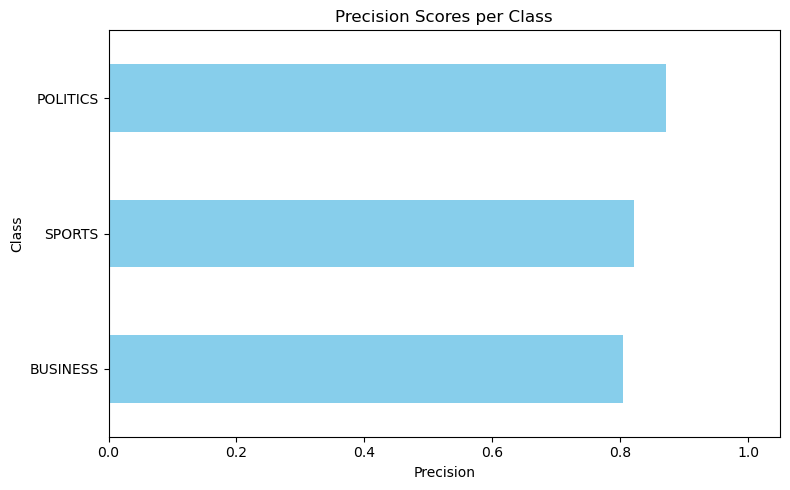

In [55]:
# Plot 1: Precision Scores
plt.figure(figsize=(8, 5))
metrics_df_rnn['precision'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Precision Scores per Class')
plt.xlabel('Precision')
plt.ylabel('Class')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

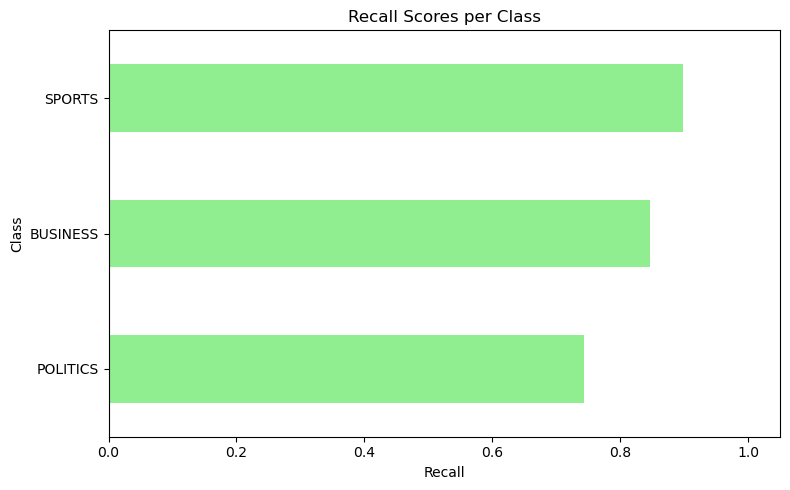

In [56]:
# Plot 2: Recall Scores
plt.figure(figsize=(8, 5))
metrics_df_rnn['recall'].sort_values().plot(kind='barh', color='lightgreen')
plt.title('Recall Scores per Class')
plt.xlabel('Recall')
plt.ylabel('Class')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

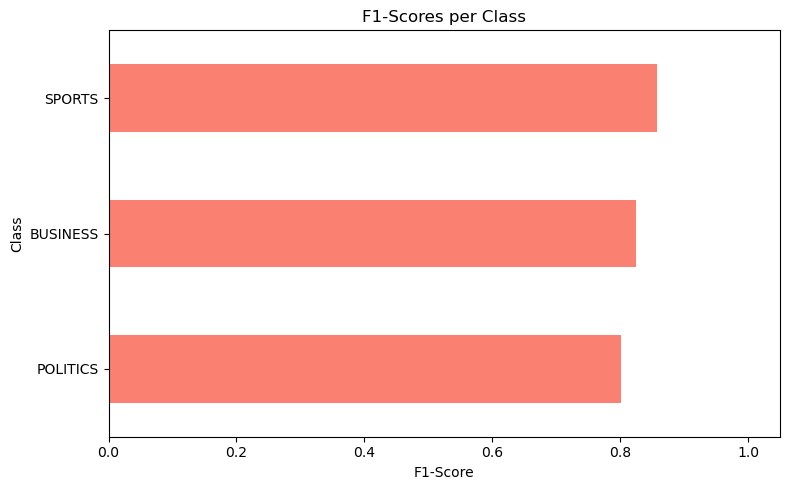

In [57]:
# Plot 3: F1-Scores
plt.figure(figsize=(8, 5))
metrics_df_rnn['f1-score'].sort_values().plot(kind='barh', color='salmon')
plt.title('F1-Scores per Class')
plt.xlabel('F1-Score')
plt.ylabel('Class')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

#### A grouped bar chart is created to compare all RNN evaluation metrics (Precision, Recall, and F1-score) across the three categories.

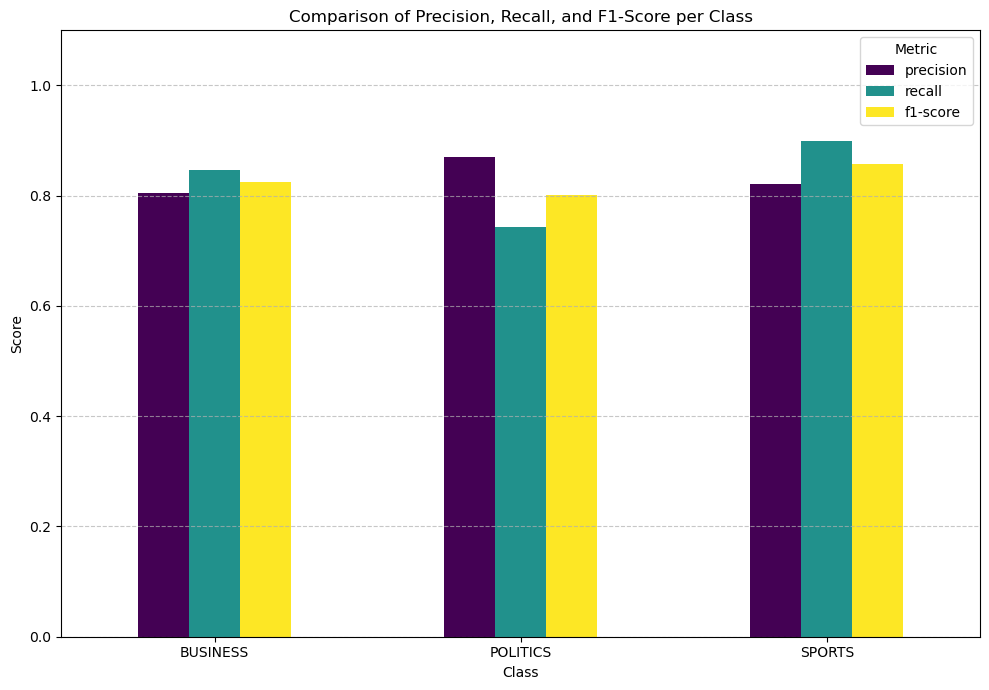

In [59]:
metrics_df_rnn.plot(kind='bar', figsize=(10, 7), colormap='viridis')
plt.title('Comparison of Precision, Recall, and F1-Score per Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Model 3: RNN using LSTM with FFN classification head

In [61]:
# Model Definition
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

NUM_CLASSES = 3 
LSTM_NODES = 128 # Nodes in the LSTM layer
BATCH_SIZE = 64  
EPOCHS = 30 

def create_lstm_ffn_model(embedding_matrix, max_len, num_classes):
    model = Sequential([
        # 1. Embedding Layer: Non-trainable Word2Vec weights
        Embedding(
            input_dim=embedding_matrix.shape[0],      # Vocab size
            output_dim=embedding_matrix.shape[1],     # Embedding dim (300)
            weights=[embedding_matrix],               # Pre-trained Word2Vec weights
            input_length=max_len,                     # Max context length
            trainable=False                           # CRUCIAL: Embeddings are NOT trainable
        ),
        
        # 2. RNN Layer: LSTM to process sequence data
        LSTM(LSTM_NODES),
        
        # 3. FFN Classification Head: Single fully connected layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Compiling the model
    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy', # Required loss function
        metrics=['accuracy']
    )
    return model

lstm_ffn_model = create_lstm_ffn_model(embedding_matrix, MAX_CONTEXT_LENGTH, NUM_CLASSES)

In [62]:
# Model Summary
lstm_ffn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     3,585,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,585,300 (13.68 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,585,300 (13.68 MB)

In [63]:
# Model Training


# Callbacks for better training control
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True, verbose=0)
]

print("\nStarting LSTM RNN Model Training...")
lstm_ffn_history = lstm_ffn_model.fit(
    X_train, 
    y_train_oh, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_val, y_val_oh), 
    callbacks=callbacks,
    verbose=1
)

print("\nLSTM RNN Model Training Complete.")


Starting LSTM RNN Model Training...
Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6954 - loss: 0.6976 - val_accuracy: 0.8127 - val_loss: 0.4584
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8407 - loss: 0.4154 - val_accuracy: 0.8293 - val_loss: 0.4414
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8566 - loss: 0.3844 - val_accuracy: 0.8340 - val_loss: 0.4297
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8585 - loss: 0.3769 - val_accuracy: 0.8227 - val_loss: 0.4306
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8598 - loss: 0.3710 - val_accuracy: 0.8280 - val_loss: 0.4233
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8731 - loss: 0.3361 - val_accuracy: 0.8407 - val_loss: 0.4434
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8797 - loss: 0.3271 - val_accuracy: 0.8367 - val_loss: 0.4232
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accur

In [64]:
# Predicting the  probabilities on the test set using the LSTM model
y_pred_probs = lstm_ffn_model.predict(X_test, verbose=0)

# Convert probabilities to class indices
y_pred_indices = np.argmax(y_pred_probs, axis=1)

# Get true indices from one-hot encoding
y_true_indices = np.argmax(y_test_oh, axis=1)

In [65]:
# Decoding Labels
target_names = le.inverse_transform(np.unique(y_true_indices))
y_true_labels = le.inverse_transform(y_true_indices)
y_pred_labels = le.inverse_transform(y_pred_indices)

In [66]:
# Computing the full classification report
rnn_ffn_report = classification_report(
    y_true_labels, 
    y_pred_labels, 
    target_names=target_names,
    output_dict=True,
    zero_division=0 
)

#### The RNN(LSTM) with FFN model's performance on the test set is calculated by generating class predictions and creating the comprehensive classification report.

In [68]:
df_report_rnn_ffn = pd.DataFrame(rnn_ffn_report).transpose()
df_per_class = df_report_rnn_ffn.loc[target_names, ['precision', 'recall', 'f1-score']]
print("LSTM RNN Classifier: Per-Class Performance on Test Data")
print(df_report_rnn_ffn.loc[target_names, ['precision', 'recall', 'f1-score']])

LSTM RNN Classifier: Per-Class Performance on Test Data
          precision  recall  f1-score
BUSINESS   0.812257   0.835  0.823471
POLITICS   0.830228   0.802  0.815870
SPORTS     0.876740   0.882  0.879362


In [69]:
# micro averages of precision, recall, and F1 score
micro_avg_value = rnn_ffn_report['accuracy']

print("\nMicro Averages (Overall Accuracy):")
print(f"  Micro Average Precision: {micro_avg_value:.4f}")
print(f"  Micro Average Recall:    {micro_avg_value:.4f}")
print(f"  Micro Average F1-score:  {micro_avg_value:.4f}")


Micro Averages (Overall Accuracy):
  Micro Average Precision: 0.8397
  Micro Average Recall:    0.8397
  Micro Average F1-score:  0.8397


In [70]:
# macro averages of precision, recall, and F1 score
print("\nMacro Averages:")
print(f"  Macro Average Precision: {rnn_ffn_report['macro avg']['precision']:.4f}")
print(f"  Macro Average Recall:    {rnn_ffn_report['macro avg']['recall']:.4f}")
print(f"  Macro Average F1-score:  {rnn_ffn_report['macro avg']['f1-score']:.4f}")


Macro Averages:
  Macro Average Precision: 0.8397
  Macro Average Recall:    0.8397
  Macro Average F1-score:  0.8396


In [71]:
metrics_df_rnn_ffn = df_report_rnn_ffn.loc[target_names, ['precision', 'recall', 'f1-score']]

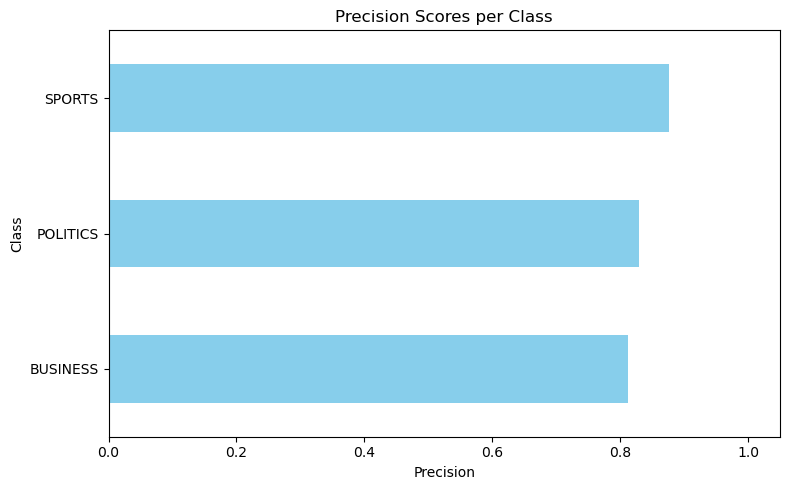

In [72]:
# Plot 1: Precision Scores
plt.figure(figsize=(8, 5))
metrics_df_rnn_ffn['precision'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Precision Scores per Class')
plt.xlabel('Precision')
plt.ylabel('Class')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

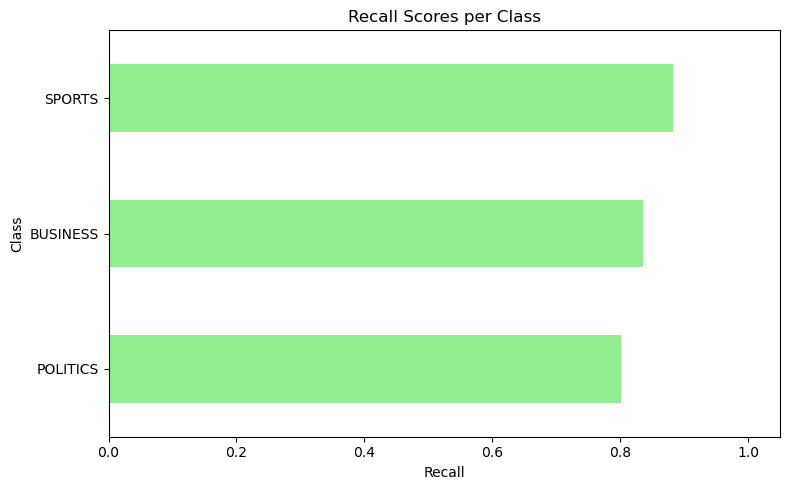

In [73]:
# Plot 2: Recall Scores
plt.figure(figsize=(8, 5))
metrics_df_rnn_ffn['recall'].sort_values().plot(kind='barh', color='lightgreen')
plt.title('Recall Scores per Class')
plt.xlabel('Recall')
plt.ylabel('Class')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

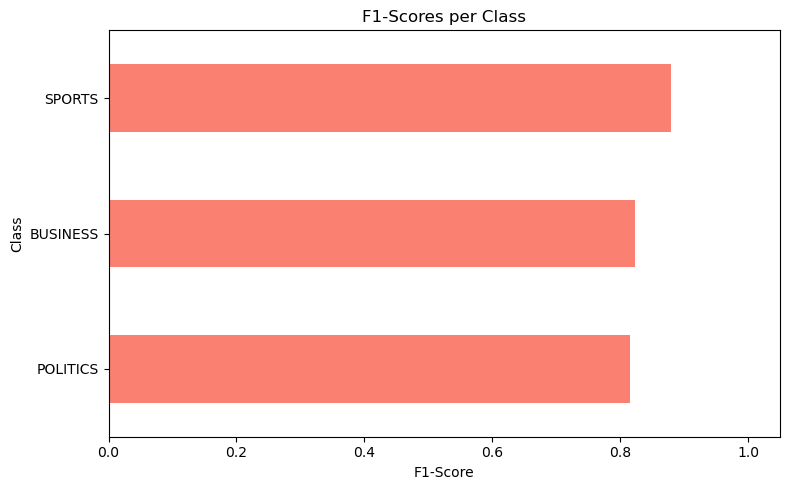

In [74]:
# Plot 3: F1-Scores
plt.figure(figsize=(8, 5))
metrics_df_rnn_ffn['f1-score'].sort_values().plot(kind='barh', color='salmon')
plt.title('F1-Scores per Class')
plt.xlabel('F1-Score')
plt.ylabel('Class')
plt.xlim(0, 1.05)
plt.tight_layout()
plt.show()

#### A grouped bar chart is created to compare all RNN(LSTM) with FFN evaluation metrics (Precision, Recall, and F1-score) across the three categories.

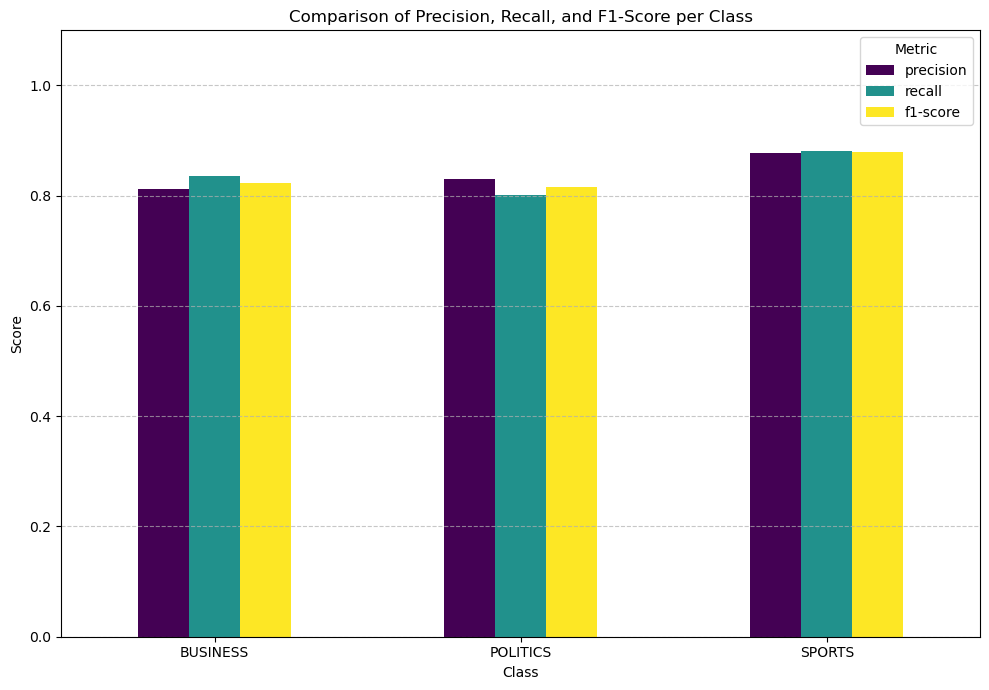

In [76]:
# Plot 4: Comparison of All Metrics
metrics_df_rnn_ffn.plot(kind='bar', figsize=(10, 7), colormap='viridis')
plt.title('Comparison of Precision, Recall, and F1-Score per Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


=== Confusion Matrix for FFN Model ===
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


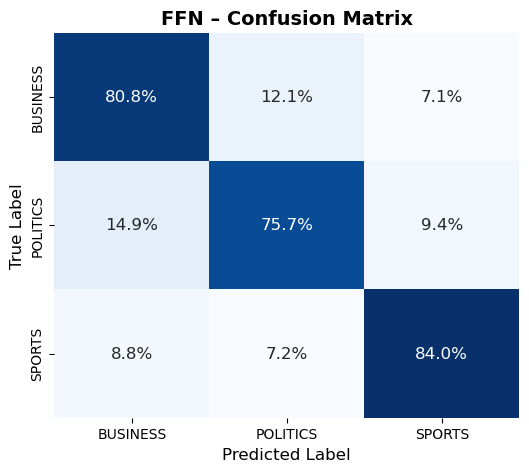


=== Confusion Matrix for RNN Model ===
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


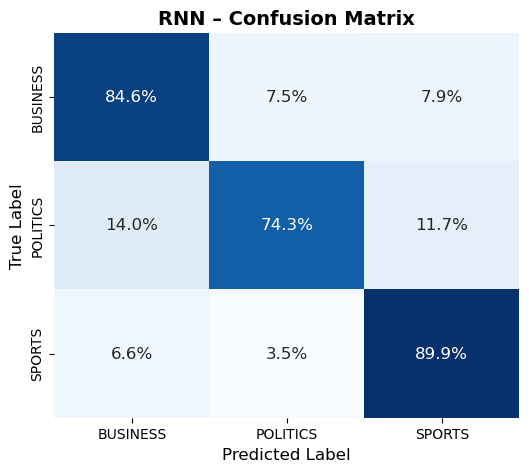


=== Confusion Matrix for LSTM + FFN Model ===
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


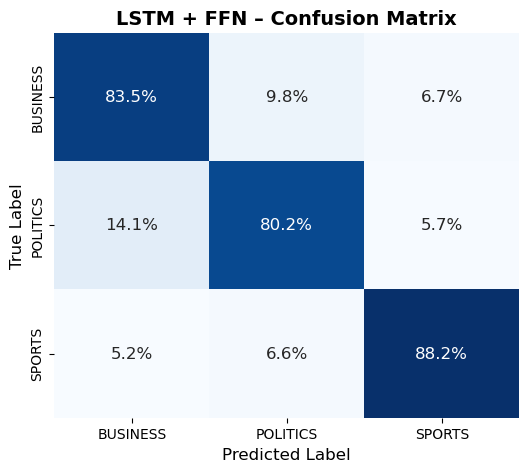

In [77]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

models = {
    "FFN": ffn_model,
    "RNN": rnn_model,
    "LSTM + FFN": lstm_ffn_model
}

for name, model in models.items():
    print(f"\n=== Confusion Matrix for {name} Model ===")
    
    # Getting predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test_oh, axis=1)

    # confusion matrix in percentages
    cm = confusion_matrix(y_true_classes, y_pred_classes, normalize='true') * 100
    labels = le.classes_

    # Creating string annotations with '%' symbol
    cm_labels = [[f"{value:.1f}%" for value in row] for row in cm]

    # Plotting heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=cm_labels, fmt="", cmap="Blues", 
                xticklabels=labels, yticklabels=labels,
                cbar=False, annot_kws={"size":12})
    
    plt.title(f"{name} – Confusion Matrix", fontsize=14, fontweight='bold')
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.show()

#### The final grouped bar chart visualizes the F1-score comparison of the FFN, RNN, and RNN(LSTM) with FFN models across the three news categories.

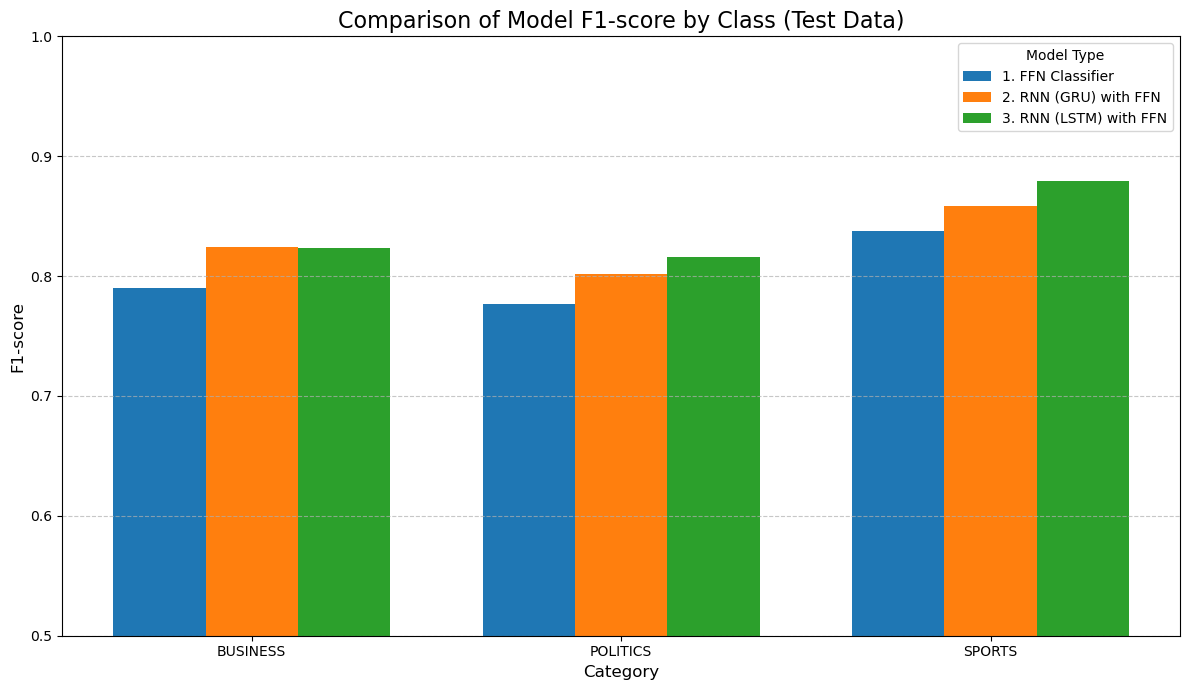

In [79]:
# Rename the index (Classes) to a column
df_ffn = metrics_df_ffn.reset_index().rename(columns={'index': 'Category'})
df_rnn = metrics_df_rnn.reset_index().rename(columns={'index': 'Category'})
df_lstm_ffn = metrics_df_rnn_ffn.reset_index().rename(columns={'index': 'Category'}) 

# Adding a model identifier column
df_ffn['Model'] = '1. FFN'
df_rnn['Model'] = '2. GRU'
df_lstm_ffn['Model'] = '3. LSTM'

# Concatenating all data into a single DataFrame
df_combined = pd.concat([df_ffn, df_rnn, df_lstm_ffn])

plt.figure(figsize=(12, 7))

# Defining categories and models
categories = target_names
models = ['1. FFN', '2. GRU', '3. LSTM']

# Setting position of bars on X-axis
bar_width = 0.25
r = np.arange(len(categories))

# Plotting bars for each model's F1-score
plt.bar(r - bar_width, 
        df_combined[df_combined['Model'] == '1. FFN']['f1-score'], 
        color='#1f77b4', width=bar_width, label='1. FFN Classifier')  # Deep Blue

plt.bar(r, 
        df_combined[df_combined['Model'] == '2. GRU']['f1-score'], 
        color='#ff7f0e', width=bar_width, label='2. RNN (GRU) with FFN')  # Orange

plt.bar(r + bar_width, 
        df_combined[df_combined['Model'] == '3. LSTM']['f1-score'], 
        color='#2ca02c', width=bar_width, label='3. RNN (LSTM) with FFN')  # Green



plt.title('Comparison of Model F1-score by Class (Test Data)', fontsize=16)
plt.ylabel('F1-score', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(r, categories)
plt.ylim(0.5, 1.0) # Setting appropriate y-limits
plt.legend(title='Model Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()